# Topic Modelling with Big ARTM

In this notebook, we will perform topic modelling on the french texts from the DFKV illustrations project. Doc for ARTM usage [here](https://bigartm.readthedocs.io/en/stable/tutorials/python_userguide/index.html).

We start by installing the package.

In [1]:
!pip install bigartm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.3 MB/s 


Then we load our Google Drive content, to be able to use our images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


And we navigate to the right directory.

In [3]:
%cd drive/MyDrive/text/

/content/drive/MyDrive/text


We start by creating our batches using the vectorizer from the package. We have our `docword.dfkv.txt` and `vocab.dfkv.txt` files (in Bag of Words UCI format) in the same folder as our notebook.

In [4]:
import artm
import matplotlib.pyplot as plt
import math

batch_vectorizer = artm.BatchVectorizer(data_path='',
                                        data_format='bow_uci',
                                        collection_name='dfkv',
                                        target_folder='data')

Then, we also need to create our dictionnary, which is in our case in `vocab.dfkv.txt`. Here the data path is where the batches are, the emplacement that was defined previously as the target folder.

In [5]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='data',
                  vocab_file_path='vocab.dfkv.txt')

Let's also define here a set of parameters that we will finetune later, there role will be explained when they are used, we can just use the default values for now.

In [61]:
NUM_TOPICS = 20 
NUM_TOKENS = 12
TAU_DECORRELATOR = 1e+5
TAU_PHI = -1.0
TAU_THETA = -0.5

And we can start to build our model ! It is basically a matrix of size "Number of words in dictionnary" X "Number of topics", which is randomly initialized.

In [6]:
# ARTM model
# We choose here the number of topics that we want in our texts
model = artm.ARTM(num_topics=NUM_TOPICS, dictionary=dictionary, cache_theta=False)

Then, we want to add ways to measure how good our model performs : scores. Let's explain breifely the ones we use, but a more complete description is available [here](https://bigartm.readthedocs.io/en/stable/tutorials/scores_descr.html)  :
- Perplexity : indicates speed of convergence of the model. The smaller the better
- Sparsity Phi : ratio of elements of the Phi matrix that are less than a given threshold. Used to control regularization, the goal is to have a sparse matrix.
- Sparsity Theta : ratio of elements of the Theta matrix that are less than a given threshold. Used to control regularization, the goal is to have a sparse matrix.
- Top Tokens : to check topic quality, will return top words for each topic. Can also compute coherence of the top tokens.

Other scores are available for the model, you can look them up at the page for scores descriptions.


In [7]:
# Adding scores
model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model.scores.add(artm.TopTokensScore(name='top_tokens_score'))
model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score_10_topics', topic_names=model.topic_names[0: 9]))
# To show the number of most probable words in each topic
model.num_tokens = NUM_TOKENS

We will also add a regularizer from the beginning (see [documentation](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html) for more infos about regularizers) : the decorrelator Phi that decorrelates columns in the Phi matrix (e.g. make topics more different), that allows to increase the interpretability of topics.

In [8]:
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer'))
model.regularizers['decorrelator_phi_regularizer'].tau = TAU_DECORRELATOR

Now we can start training the model ! We use the fit_offline algorithm, which does many passes through the collection, one pass through the single document (optional), only one update of the PHI matrix on one collection pass (at the end of the pass).

In [9]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Let us look at our scores throughout the different iterations

In [52]:
def plot_scores(score_tracker):
  to_plot = [k for k in score_tracker.keys() if k != "top_tokens_score"]
  n_scores = len(to_plot)
  columns = 2
  lines = math.ceil(n_scores/2)
  fig, axs = plt.subplots(lines, columns, figsize=(8*lines, 8))
  for i, score in enumerate(to_plot):
    axs[math.ceil(i/2) - 1][i%2].plot(range(len(model.score_tracker[score].value)), model.score_tracker[score].value)
    axs[math.ceil(i/2) - 1][i%2].title.set_text(score)
  fig.suptitle('Different scores of the model through iterations')

In [55]:
def print_topics():
  saved_top_tokens = model.score_tracker['top_tokens_score'].last_tokens

  for topic_name in model.topic_names:
    print(saved_top_tokens[topic_name])

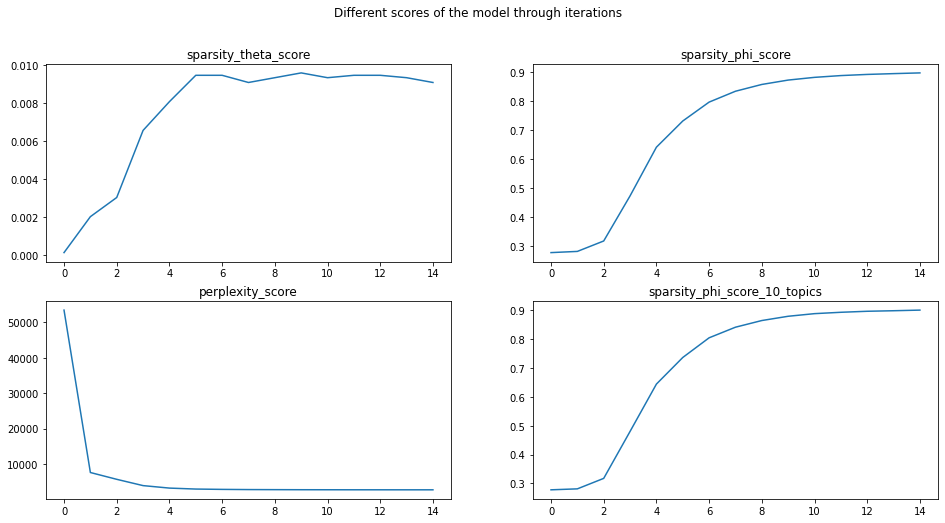

In [53]:
plot_scores(model.score_tracker)

In [56]:
print_topics()

['von', b'mar\xe9es', 'temps', 'exposition', 'mieux', 'france', b'po\xe8tes', b'\xe9t\xe9', 'fut', 'hans']
['busch', b'th\xe9\xe2tre', 'faire', 'bien', 'grand', b'fran\xe7ais', 'vie', 'petit', 'temps', 'france']
['der', 'die', 'und', 'in', 'das', 'peinture', 'zu', 'ist', 'nature', b'mus\xe9e']
['lenbach', 'suisse', 'oeuvre', b'mus\xe9e', 'venise', 'oeuvres', 'fut', 'exposition', 'artiste', 'maison']
['durer', 'peinture', 'portrait', b'si\xe8cle', b'mus\xe9e', 'allemagne', 'courbet', 'artiste', 'allemande', b'ma\xeetre']
['galerie', 'burgkmair', 'exposition', 'augsbourg', 'liebermann', 'peintres', 'berlin', b'\x9cuvres', 'bien', 'kandinsky']
['fig', 'exposition', b'\x9cuvre', 'grand', 'architecture', b'\x9cuvres', 'bien', 'faire', 'paris', 'ans']
['galerie', 'peinture', 'bien', 'peintre', 'holbein', 'rue', b'\x9cuvre', 'tableaux', b'\x9cuvres', b'mus\xe9e']
['maison', 'gropius', 'air', b'mus\xe9e', 'rue', 'architecture', 'salle', b'th\xe9\xe2tre', 'paris', 'avril']
['hoffmann', 'artiste

After a few passes, we see that the different scores have all converged.However, we could get even better topics by adding more regulizers. Again, more information about them can be found in the [documentation](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html).
- Smooth Sparse Phi : simply smooth or sparse all values in the Phi matrix
- Smooth Sparse Theta : simply smooth or sparse all values in the Theta matrix

In [54]:
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer'))

model.regularizers['sparse_phi_regularizer'].tau = TAU_PHI
model.regularizers['sparse_theta_regularizer'].tau = TAU_THETA

And we fit for 15 more passes the model, with the new regularizers.

In [57]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

And again look at the scores and topics found

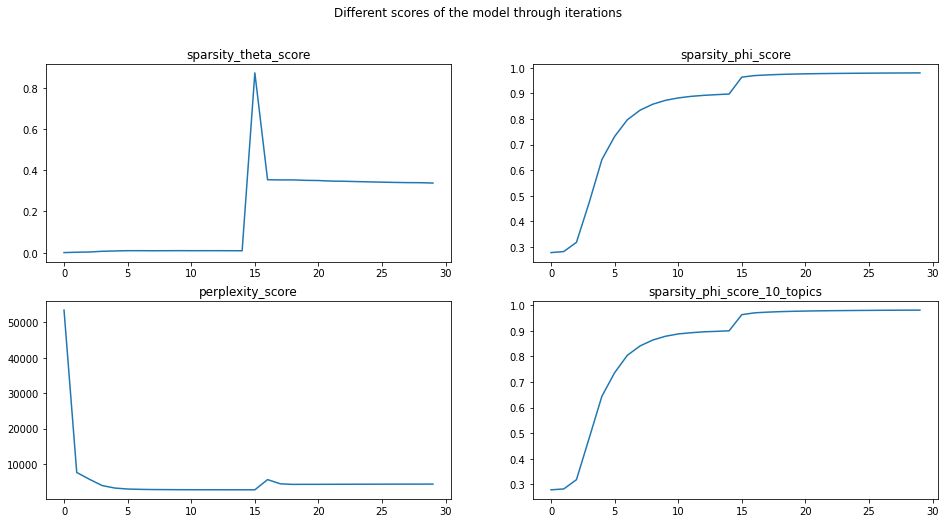

In [58]:
plot_scores(model.score_tracker)

In [59]:
print_topics()

['von', b'mar\xe9es', b'po\xe8tes', 'lettres', 'yeux', 'mieux', 'voltaire', 'internationale', 'france', 'bruit']
['busch', b'th\xe9\xe2tre', 'heures', 'petit', 'fut', b'fran\xe7ais', 'faire', 'lettre', 'petite', 'grand']
['der', 'und', 'die', 'in', 'das', 'zu', 'ist', 'mit', 'den', 'ein']
['oeuvre', 'suisse', 'lenbach', 'venise', 'oeuvres', b'gen\xe8ve', 'palais', 'collaboration', 'talent', b'pr\xe9cieux']
['peinture', 'durer', b'si\xe8cle', 'portrait', b'ma\xeetre', 'artiste', 'holbein', 'fut', 'artistes', 'oeuvre']
['liebermann', 'picasso', 'photographie', 'burgkmair', 'van', 'augsbourg', b'cin\xe9ma', 'partir', 'modernes', 'meilleurs']
['fig', 'architecture', 'amour', 'max', 'livre', 'forme', 'pierre', 'ans', 'berlin', b'progr\xe8s']
['galerie', 'peinture', b'\x9cuvre', b'\x9cuvres', 'peintre', 'exposition', b'\xe9t\xe9', 'rue', 'aujourd', 'faire']
['maison', 'gropius', 'air', 'architecture', 'salle', 'maisons', 'construction', 'vue', 'avril', b'\xe9tage']
['russe', 'composition', b